# Movement Recognition

This notebook contains the main code for the movement recognition tasks. It loads the participant data, preprocesses it and uses this data to train the different models either on the execution task, or on the observation task.

### Import librairies

In [68]:
from utils import *
from dataset import *
from constants import *
from models.BaseModels import *
from models.DeepModels import *
from models.DeepUtils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dataset import Participant
from torch.utils.data import DataLoader

# Reproducibility
seed_num = RANDOM_STATE # This seed will be used for all random number generators
torch.use_deterministic_algorithms(True) # PyTorch will use deterministic algorithms fro operations with stochastic behavior like dropout
random.seed(seed_num) # Python's random will use seed_num
np.random.seed(seed_num) # NumPy's random number generator will use seed_num
torch.manual_seed(seed_num) # PyTorch's random number will use seed_num

### Data loading

Change here the participant to load.

In [69]:
part_name = 's6'
use_saved = True

In [70]:
if use_saved and os.path.exists(f'saved/{part_name}.pkl'):
    participant = Participant.load_from_pickle(f'saved/{part_name}.pkl')
else:
    participant = Participant(part_name, data_path=DATA_PATH_NOTEBOOK, alpha=ALPHA)
    saved_dir = os.path.join(os.getcwd(), 'saved')
    if not os.path.exists(saved_dir):
        os.makedirs(saved_dir)
    with open(f'saved/{part_name}.pkl', 'wb') as f:
        pickle.dump(participant, f, pickle.HIGHEST_PROTOCOL)

In [71]:
test_size = 0.3
pca_expl_var = 0.95

### Possible hyperparameters for MLP models.

In [72]:
models = {
    '8_8_01': {
        'layers': (8, 8),
        'lr': 0.1
    },
    '8_16_01': {
        'layers': (8, 16),
        'lr': 0.1
    },
    '16_16_01': {
        'layers': (16, 16),
        'lr': 0.1
    },
    '32_16_01': {
        'layers': (32, 16),
        'lr': 0.1
    }, # more complex, might require higher learning rate
    '32_16_02': {
        'layers': (32, 16),
        'lr': 0.2
    }
}

## Execution

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [73]:
if use_saved and os.path.exists(f'saved/ex_features_{part_name}_mvt.h5'):
    ex_features = pd.read_hdf(f'saved/ex_features_{part_name}_mvt.h5', 'df')
else:
    ex_features = participant.get_features_all_sessions_mvt('E')
    ex_features.to_hdf(f'saved/ex_features_{part_name}_mvt.h5', 'df', mode='w', data_columns=True)

In [74]:
print(f'The dataset contains {ex_features.shape[0]} samples and {ex_features.shape[1]} features.')
print(f'The {len(participant.relevant_channels_ex)} relevant channels are located in the following locations:')
regions = [participant.channels_locations[i] for i in [channel.idx for channel in participant.relevant_channels_ex]]
channels_per_regions = {}
for region in set(regions):
    channels_per_regions[region] = regions.count(region)
print(channels_per_regions)

The dataset contains 128 samples and 4897 features.
The 68 relevant channels are located in the following locations:
{'WM_paracentral': 1, 'supramarginal': 3, 'insula': 3, 'WM_insula': 1, 'precentral': 26, 'paracentral': 3, 'postcentral': 16, 'WM_precentral': 6, 'superiorfrontal': 5, 'caudalmiddlefrontal': 4}


Let's create a baseline by taking the same number of channels, but without checking whether they are responsive:

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [75]:
if use_saved and os.path.exists(f'saved/ex_baseline_features_{part_name}_mvt.h5'):
    ex_baseline_features = pd.read_hdf(f'saved/ex_baseline_features_{part_name}_mvt.h5', 'df')
else:
    ex_baseline_features = participant.get_features_all_sessions_unresponsive(movtype='E')
    ex_baseline_features.to_hdf(f'saved/ex_baseline_features_{part_name}_mvt.h5', 'df', mode='w', data_columns=True)

In [76]:
print(f'The baseline dataset contains {ex_baseline_features.shape[0]} samples and {ex_baseline_features.shape[1]} features.')

The baseline dataset contains 128 samples and 2737 features.


In [77]:
accuracies_ex = {}
accuracies_ex_baseline = {}

### Train a model on the baseline features (Logistic Regression)

In [78]:
X = ex_baseline_features.drop('label', axis=1)
y = ex_baseline_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['LR'] = accuracy

Accuracy: 0.64


#### With PCA

In [79]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['LR PCA'] = accuracy

Accuracy: 0.59


### Train a model (SVM)

In [80]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['SVM'] = accuracy

Accuracy: 0.62


#### With PCA

In [81]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['SVM PCA'] = accuracy

Accuracy: 0.56


### Train a model (Random Forest)

In [82]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['RF'] = accuracy

Accuracy: 0.56


### Train a model (Multi-Layer Perceptron)

In [83]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

We train the MLP with different layers and learning rate, and test on the model with the lowest final accuracy loss.

In [84]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False)

    trainer = Trainer(mlp, params['lr'], 10, 1e-2, save_path=f'saved/mlpMRexbaseline_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Epoch 1/10 - Training:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 338.25it/s]


Epoch: 1 	Training Loss: 2.268657 	Training Acc: 0.539326


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.49it/s]


Epoch: 1 	Validation Loss: 0.683601 	Validation Acc: 0.578947


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 442.31it/s]


Epoch: 2 	Training Loss: 0.720301 	Training Acc: 0.494382


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.46it/s]


Epoch: 2 	Validation Loss: 0.704052 	Validation Acc: 0.421053


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 460.02it/s]


Epoch: 3 	Training Loss: 4.524558 	Training Acc: 0.617978


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.99it/s]


Epoch: 3 	Validation Loss: 0.616051 	Validation Acc: 0.631579


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 469.39it/s]


Epoch: 4 	Training Loss: 1.160459 	Training Acc: 0.494382


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.79it/s]


Epoch: 4 	Validation Loss: 0.684331 	Validation Acc: 0.578947


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 522.73it/s]


Epoch: 5 	Training Loss: 0.701738 	Training Acc: 0.494382


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.58it/s]


Epoch: 5 	Validation Loss: 0.685741 	Validation Acc: 0.578947


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 442.33it/s]


Epoch: 6 	Training Loss: 0.700962 	Training Acc: 0.438202


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.13it/s]


Epoch: 6 	Validation Loss: 0.706635 	Validation Acc: 0.421053


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 489.36it/s]


Epoch: 7 	Training Loss: 0.706261 	Training Acc: 0.505618


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.79it/s]


Epoch: 7 	Validation Loss: 0.696050 	Validation Acc: 0.421053


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 479.16it/s]


Epoch: 8 	Training Loss: 0.696618 	Training Acc: 0.494382


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.79it/s]


Epoch: 8 	Validation Loss: 0.692459 	Validation Acc: 0.578947


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 433.96it/s]


Epoch: 9 	Training Loss: 0.697474 	Training Acc: 0.460674


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.66it/s]


Epoch: 9 	Validation Loss: 0.707805 	Validation Acc: 0.421053


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 511.14it/s]


Epoch: 10 	Training Loss: 0.703996 	Training Acc: 0.516854


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.72it/s]


Epoch: 10 	Validation Loss: 0.686012 	Validation Acc: 0.578947


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 469.40it/s]


Epoch: 1 	Training Loss: 5.133850 	Training Acc: 0.516854


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.85it/s]


Epoch: 1 	Validation Loss: 0.645374 	Validation Acc: 0.684211


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 418.17it/s]


Epoch: 2 	Training Loss: 0.890690 	Training Acc: 0.483146


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.32it/s]


Epoch: 2 	Validation Loss: 1.932325 	Validation Acc: 0.421053


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 383.34it/s]


Epoch: 3 	Training Loss: 0.710661 	Training Acc: 0.449438


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 714.36it/s]


Epoch: 3 	Validation Loss: 1.928690 	Validation Acc: 0.526316


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 315.06it/s]


Epoch: 4 	Training Loss: 0.700239 	Training Acc: 0.426966


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1000.02it/s]


Epoch: 4 	Validation Loss: 1.868615 	Validation Acc: 0.421053


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 370.98it/s]


Epoch: 5 	Training Loss: 0.698211 	Training Acc: 0.426966


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.09it/s]


Epoch: 5 	Validation Loss: 1.781500 	Validation Acc: 0.578947


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 399.96it/s]


Epoch: 6 	Training Loss: 0.702906 	Training Acc: 0.494382


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 999.79it/s]


Epoch: 6 	Validation Loss: 1.716771 	Validation Acc: 0.421053


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 418.19it/s]


Epoch: 7 	Training Loss: 0.698492 	Training Acc: 0.494382


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1664.93it/s]


Epoch: 7 	Validation Loss: 1.646297 	Validation Acc: 0.421053


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 389.83it/s]


Epoch: 8 	Training Loss: 0.694406 	Training Acc: 0.505618


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.58it/s]


Epoch: 8 	Validation Loss: 1.562778 	Validation Acc: 0.578947


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 451.00it/s]


Epoch: 9 	Training Loss: 0.713311 	Training Acc: 0.471910


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.72it/s]


Epoch: 9 	Validation Loss: 1.520798 	Validation Acc: 0.421053


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 460.01it/s]


Epoch: 10 	Training Loss: 0.697163 	Training Acc: 0.471910


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.18it/s]


Epoch: 10 	Validation Loss: 1.439208 	Validation Acc: 0.578947


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 348.48it/s]


Epoch: 1 	Training Loss: 8.554935 	Training Acc: 0.573034


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.05it/s]


Epoch: 1 	Validation Loss: 1.658130 	Validation Acc: 0.578947


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 396.56it/s]


Epoch: 2 	Training Loss: 4.444326 	Training Acc: 0.730337


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1668.25it/s]


Epoch: 2 	Validation Loss: 22.600072 	Validation Acc: 0.631579


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 396.55it/s]


Epoch: 3 	Training Loss: 15.120084 	Training Acc: 0.741573


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.79it/s]


Epoch: 3 	Validation Loss: 18.880995 	Validation Acc: 0.684211


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 383.34it/s]


Epoch: 4 	Training Loss: 2.827270 	Training Acc: 0.674157


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 999.88it/s]


Epoch: 4 	Validation Loss: 9.123339 	Validation Acc: 0.421053


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 396.55it/s]


Epoch: 5 	Training Loss: 0.545957 	Training Acc: 0.674157


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.13it/s]


Epoch: 5 	Validation Loss: 8.644417 	Validation Acc: 0.421053


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 418.18it/s]


Epoch: 6 	Training Loss: 0.542598 	Training Acc: 0.674157


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.13it/s]


Epoch: 6 	Validation Loss: 8.105769 	Validation Acc: 0.421053


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 479.18it/s]


Epoch: 7 	Training Loss: 0.556186 	Training Acc: 0.674157


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.73it/s]


Epoch: 7 	Validation Loss: 7.609676 	Validation Acc: 0.421053


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 489.34it/s]


Epoch: 8 	Training Loss: 0.550138 	Training Acc: 0.674157


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.57it/s]


Epoch: 8 	Validation Loss: 7.130517 	Validation Acc: 0.421053


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 460.00it/s]


Epoch: 9 	Training Loss: 0.544752 	Training Acc: 0.674157


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.76it/s]


Epoch: 9 	Validation Loss: 6.721268 	Validation Acc: 0.421053


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 459.99it/s]


Epoch: 10 	Training Loss: 0.545601 	Training Acc: 0.674157


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1673.84it/s]


Epoch: 10 	Validation Loss: 6.304551 	Validation Acc: 0.421053


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 353.83it/s]


Epoch: 1 	Training Loss: 41.267410 	Training Acc: 0.539326


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.66it/s]


Epoch: 1 	Validation Loss: 3.739935 	Validation Acc: 0.578947


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 399.92it/s]


Epoch: 2 	Training Loss: 1.584090 	Training Acc: 0.438202


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.02it/s]


Epoch: 2 	Validation Loss: 0.621305 	Validation Acc: 0.526316


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 377.04it/s]


Epoch: 3 	Training Loss: 1.046020 	Training Acc: 0.505618


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.79it/s]


Epoch: 3 	Validation Loss: 0.668388 	Validation Acc: 0.473684


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 377.05it/s]


Epoch: 4 	Training Loss: 0.684606 	Training Acc: 0.460674


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.73it/s]


Epoch: 4 	Validation Loss: 0.657547 	Validation Acc: 0.473684


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 418.17it/s]


Epoch: 5 	Training Loss: 0.682115 	Training Acc: 0.528090


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.60it/s]


Epoch: 5 	Validation Loss: 0.668418 	Validation Acc: 0.473684


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 410.71it/s]


Epoch: 6 	Training Loss: 0.681461 	Training Acc: 0.528090


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.87it/s]


Epoch: 6 	Validation Loss: 0.659208 	Validation Acc: 0.473684


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 459.99it/s]


Epoch: 7 	Training Loss: 0.681436 	Training Acc: 0.516854


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1668.25it/s]


Epoch: 7 	Validation Loss: 0.653771 	Validation Acc: 0.578947


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 450.99it/s]


Epoch: 8 	Training Loss: 0.684745 	Training Acc: 0.426966


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.39it/s]


Epoch: 8 	Validation Loss: 0.654023 	Validation Acc: 0.578947


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 418.18it/s]


Epoch: 9 	Training Loss: 0.687477 	Training Acc: 0.449438


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.52it/s]


Epoch: 9 	Validation Loss: 0.667508 	Validation Acc: 0.473684


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 451.00it/s]


Epoch: 10 	Training Loss: 0.690038 	Training Acc: 0.528090


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.99it/s]


Epoch: 10 	Validation Loss: 0.665666 	Validation Acc: 0.473684


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 410.71it/s]


Epoch: 1 	Training Loss: 101.060414 	Training Acc: 0.606742


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.73it/s]


Epoch: 1 	Validation Loss: 165.113039 	Validation Acc: 0.421053


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 396.57it/s]


Epoch: 2 	Training Loss: 25.172693 	Training Acc: 0.426966


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.18it/s]


Epoch: 2 	Validation Loss: 0.746761 	Validation Acc: 0.421053


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 442.29it/s]


Epoch: 3 	Training Loss: 0.705962 	Training Acc: 0.516854


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.18it/s]


Epoch: 3 	Validation Loss: 0.682158 	Validation Acc: 0.578947


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 410.71it/s]


Epoch: 4 	Training Loss: 0.699043 	Training Acc: 0.505618


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.86it/s]


Epoch: 4 	Validation Loss: 0.744426 	Validation Acc: 0.421053


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 418.17it/s]


Epoch: 5 	Training Loss: 0.705938 	Training Acc: 0.471910


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.09it/s]


Epoch: 5 	Validation Loss: 0.684997 	Validation Acc: 0.578947


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 418.19it/s]


Epoch: 6 	Training Loss: 0.744095 	Training Acc: 0.426966


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.46it/s]


Epoch: 6 	Validation Loss: 0.680687 	Validation Acc: 0.578947


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 433.96it/s]


Epoch: 7 	Training Loss: 0.718948 	Training Acc: 0.550562


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2500.18it/s]


Epoch: 7 	Validation Loss: 0.744619 	Validation Acc: 0.421053


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 446.49it/s]


Epoch: 8 	Training Loss: 0.721432 	Training Acc: 0.471910


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1668.64it/s]


Epoch: 8 	Validation Loss: 0.684149 	Validation Acc: 0.578947


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 338.24it/s]


Epoch: 9 	Training Loss: 0.706202 	Training Acc: 0.550562


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.02it/s]


Epoch: 9 	Validation Loss: 0.824328 	Validation Acc: 0.421053


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 323.94it/s]


Epoch: 10 	Training Loss: 0.763872 	Training Acc: 0.494382


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.17it/s]

Epoch: 10 	Validation Loss: 0.680692 	Validation Acc: 0.578947
Model 8_8_01 Validation Loss: 0.6860
Model 8_16_01 Validation Loss: 1.4392
Model 16_16_01 Validation Loss: 6.3046
Model 32_16_01 Validation Loss: 0.6657
Model 32_16_02 Validation Loss: 0.6807


For s6, the best model has 2 layers of 32 and 16 neurons and a learning rate of 0.1.

In [85]:
mlp = MLP(X_train.shape[1], 2, layers=models['32_16_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpMRexbaseline_32_16_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_ex_baseline['MLP'] = acc

Accuracy: 0.55


## Let's now do the analysis for the responsive channels

In [86]:
X = ex_features.drop('label', axis=1)
y = ex_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

### Train a model (Logistic Regression)

In [87]:
logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['LR'] = accuracy

Accuracy: 0.77


#### With PCA

In [88]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['LR PCA'] = accuracy

Accuracy: 0.69


### Train a model (SVM)

In [89]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['SVM'] = accuracy

Accuracy: 0.62


#### With PCA

In [90]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['SVM PCA'] = accuracy

Accuracy: 0.56


### Train a model (Random Forest)

In [91]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['RF'] = accuracy

Accuracy: 0.56


### Train a model (Multi-Layer Perceptron)

In [92]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

We train the MLP with different layers and learning rate, and test on the model with the lowest final accuracy loss.

In [93]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False)

    trainer = Trainer(mlp, params['lr'], 10, 1e-2, save_path=f'saved/mlpMRex_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 255.56it/s]


Epoch: 1 	Training Loss: 2.456735 	Training Acc: 0.460674


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.66it/s]


Epoch: 1 	Validation Loss: 0.766106 	Validation Acc: 0.421053


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 221.16it/s]


Epoch: 2 	Training Loss: 3.125662 	Training Acc: 0.595506


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 999.74it/s]


Epoch: 2 	Validation Loss: 5.518871 	Validation Acc: 0.368421


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 242.11it/s]


Epoch: 3 	Training Loss: 4.930331 	Training Acc: 0.550562


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.79it/s]


Epoch: 3 	Validation Loss: 0.703419 	Validation Acc: 0.421053


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 211.01it/s]


Epoch: 4 	Training Loss: 0.690716 	Training Acc: 0.539326


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.54it/s]


Epoch: 4 	Validation Loss: 0.684079 	Validation Acc: 0.578947


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 291.14it/s]


Epoch: 5 	Training Loss: 0.716988 	Training Acc: 0.483146


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.02it/s]


Epoch: 5 	Validation Loss: 0.712964 	Validation Acc: 0.421053


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 132.18it/s]


Epoch: 6 	Training Loss: 0.722412 	Training Acc: 0.449438


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 263.14it/s]


Epoch: 6 	Validation Loss: 0.686896 	Validation Acc: 0.578947


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 302.64it/s]


Epoch: 7 	Training Loss: 0.709150 	Training Acc: 0.404494


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 999.60it/s]


Epoch: 7 	Validation Loss: 0.689144 	Validation Acc: 0.578947


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 277.11it/s]


Epoch: 8 	Training Loss: 0.723819 	Training Acc: 0.483146


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.05it/s]


Epoch: 8 	Validation Loss: 0.691243 	Validation Acc: 0.578947


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 319.45it/s]


Epoch: 9 	Training Loss: 0.706113 	Training Acc: 0.426966


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.72it/s]


Epoch: 9 	Validation Loss: 0.690833 	Validation Acc: 0.578947


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 306.67it/s]


Epoch: 10 	Training Loss: 0.701487 	Training Acc: 0.483146


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.79it/s]


Epoch: 10 	Validation Loss: 0.698744 	Validation Acc: 0.421053


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 315.06it/s]


Epoch: 1 	Training Loss: 3.855514 	Training Acc: 0.528090


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.94it/s]


Epoch: 1 	Validation Loss: 0.751254 	Validation Acc: 0.421053


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 348.48it/s]


Epoch: 2 	Training Loss: 0.697863 	Training Acc: 0.516854


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2501.37it/s]


Epoch: 2 	Validation Loss: 0.685670 	Validation Acc: 0.578947


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 365.07it/s]


Epoch: 3 	Training Loss: 0.708437 	Training Acc: 0.483146


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.42it/s]


Epoch: 3 	Validation Loss: 0.694702 	Validation Acc: 0.421053


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 353.84it/s]


Epoch: 4 	Training Loss: 0.703515 	Training Acc: 0.438202


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 834.85it/s]


Epoch: 4 	Validation Loss: 0.706379 	Validation Acc: 0.421053


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 348.48it/s]


Epoch: 5 	Training Loss: 0.699644 	Training Acc: 0.505618


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.12it/s]


Epoch: 5 	Validation Loss: 0.690512 	Validation Acc: 0.578947


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 270.59it/s]


Epoch: 6 	Training Loss: 0.702117 	Training Acc: 0.494382


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.98it/s]


Epoch: 6 	Validation Loss: 0.687856 	Validation Acc: 0.578947


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 267.44it/s]


Epoch: 7 	Training Loss: 0.740711 	Training Acc: 0.449438


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 999.98it/s]


Epoch: 7 	Validation Loss: 0.681718 	Validation Acc: 0.578947


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 143.75it/s]


Epoch: 8 	Training Loss: 0.722756 	Training Acc: 0.415730


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 142.86it/s]


Epoch: 8 	Validation Loss: 0.698862 	Validation Acc: 0.421053


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 258.43it/s]


Epoch: 9 	Training Loss: 0.701439 	Training Acc: 0.438202


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.02it/s]


Epoch: 9 	Validation Loss: 0.692833 	Validation Acc: 0.578947


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 389.83it/s]


Epoch: 10 	Training Loss: 0.703687 	Training Acc: 0.438202


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.13it/s]


Epoch: 10 	Validation Loss: 0.696880 	Validation Acc: 0.421053


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 377.04it/s]


Epoch: 1 	Training Loss: 9.415618 	Training Acc: 0.606742


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.49it/s]


Epoch: 1 	Validation Loss: 4.639442 	Validation Acc: 0.684211


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 396.53it/s]


Epoch: 2 	Training Loss: 14.131015 	Training Acc: 0.516854


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2498.10it/s]


Epoch: 2 	Validation Loss: 1.202956 	Validation Acc: 0.421053


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 319.45it/s]


Epoch: 3 	Training Loss: 3.959161 	Training Acc: 0.550562


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 999.98it/s]


Epoch: 3 	Validation Loss: 0.676383 	Validation Acc: 0.473684


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 227.72it/s]


Epoch: 4 	Training Loss: 0.669774 	Training Acc: 0.539326


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.17it/s]


Epoch: 4 	Validation Loss: 0.705070 	Validation Acc: 0.421053


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 323.95it/s]


Epoch: 5 	Training Loss: 0.675899 	Training Acc: 0.494382


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.09it/s]


Epoch: 5 	Validation Loss: 0.690300 	Validation Acc: 0.578947


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 319.43it/s]


Epoch: 6 	Training Loss: 0.674358 	Training Acc: 0.505618


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.72it/s]


Epoch: 6 	Validation Loss: 0.696938 	Validation Acc: 0.421053


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 353.84it/s]


Epoch: 7 	Training Loss: 0.680703 	Training Acc: 0.528090


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.92it/s]


Epoch: 7 	Validation Loss: 0.703788 	Validation Acc: 0.421053


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 302.63it/s]


Epoch: 8 	Training Loss: 0.696253 	Training Acc: 0.516854


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 832.70it/s]


Epoch: 8 	Validation Loss: 0.699108 	Validation Acc: 0.421053


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 377.07it/s]


Epoch: 9 	Training Loss: 0.690681 	Training Acc: 0.460674


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.54it/s]


Epoch: 9 	Validation Loss: 0.681578 	Validation Acc: 0.578947


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 383.33it/s]


Epoch: 10 	Training Loss: 0.679302 	Training Acc: 0.483146


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1000.07it/s]


Epoch: 10 	Validation Loss: 0.704299 	Validation Acc: 0.421053


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 310.81it/s]


Epoch: 1 	Training Loss: 9.895055 	Training Acc: 0.539326


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.52it/s]


Epoch: 1 	Validation Loss: 2.101815 	Validation Acc: 0.421053


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 338.24it/s]


Epoch: 2 	Training Loss: 5.514689 	Training Acc: 0.460674


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.46it/s]


Epoch: 2 	Validation Loss: 0.681344 	Validation Acc: 0.578947


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 389.83it/s]


Epoch: 3 	Training Loss: 0.699601 	Training Acc: 0.483146


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.45it/s]


Epoch: 3 	Validation Loss: 0.701039 	Validation Acc: 0.421053


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 343.30it/s]


Epoch: 4 	Training Loss: 0.710233 	Training Acc: 0.471910


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.85it/s]


Epoch: 4 	Validation Loss: 0.686784 	Validation Acc: 0.578947


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 310.82it/s]


Epoch: 5 	Training Loss: 0.703449 	Training Acc: 0.404494


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.46it/s]


Epoch: 5 	Validation Loss: 0.688382 	Validation Acc: 0.578947


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 377.04it/s]


Epoch: 6 	Training Loss: 0.716301 	Training Acc: 0.415730


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2501.67it/s]


Epoch: 6 	Validation Loss: 0.707508 	Validation Acc: 0.421053


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 353.86it/s]


Epoch: 7 	Training Loss: 0.697724 	Training Acc: 0.449438


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.87it/s]


Epoch: 7 	Validation Loss: 0.690496 	Validation Acc: 0.578947


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 212.96it/s]


Epoch: 8 	Training Loss: 0.700965 	Training Acc: 0.460674


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.79it/s]


Epoch: 8 	Validation Loss: 0.701054 	Validation Acc: 0.421053


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 343.28it/s]


Epoch: 9 	Training Loss: 0.723864 	Training Acc: 0.494382


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.57it/s]


Epoch: 9 	Validation Loss: 0.684906 	Validation Acc: 0.578947


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 319.44it/s]


Epoch: 10 	Training Loss: 0.719106 	Training Acc: 0.460674


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.72it/s]


Epoch: 10 	Validation Loss: 0.700834 	Validation Acc: 0.421053


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 280.49it/s]


Epoch: 1 	Training Loss: 31.637337 	Training Acc: 0.494382


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1668.51it/s]


Epoch: 1 	Validation Loss: 45.807756 	Validation Acc: 0.631579


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 267.44it/s]


Epoch: 2 	Training Loss: 24.215994 	Training Acc: 0.595506


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 833.10it/s]


Epoch: 2 	Validation Loss: 23.279966 	Validation Acc: 0.578947


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 306.67it/s]


Epoch: 3 	Training Loss: 21.072906 	Training Acc: 0.561798


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1669.31it/s]


Epoch: 3 	Validation Loss: 130.184781 	Validation Acc: 0.421053


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 319.45it/s]


Epoch: 4 	Training Loss: 0.693057 	Training Acc: 0.449438


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 999.60it/s]


Epoch: 4 	Validation Loss: 104.999044 	Validation Acc: 0.421053


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 294.87it/s]


Epoch: 5 	Training Loss: 0.692228 	Training Acc: 0.483146


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.39it/s]


Epoch: 5 	Validation Loss: 90.313722 	Validation Acc: 0.526316


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 359.37it/s]


Epoch: 6 	Training Loss: 0.699229 	Training Acc: 0.426966


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.35it/s]


Epoch: 6 	Validation Loss: 78.638355 	Validation Acc: 0.526316


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 150.33it/s]


Epoch: 7 	Training Loss: 0.695355 	Training Acc: 0.426966


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 454.53it/s]


Epoch: 7 	Validation Loss: 68.565881 	Validation Acc: 0.526316


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 306.67it/s]


Epoch: 8 	Training Loss: 0.688566 	Training Acc: 0.449438


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1000.12it/s]


Epoch: 8 	Validation Loss: 59.822135 	Validation Acc: 0.421053


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 302.64it/s]


Epoch: 9 	Training Loss: 0.704199 	Training Acc: 0.449438


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1000.17it/s]


Epoch: 9 	Validation Loss: 52.184634 	Validation Acc: 0.421053


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 244.69it/s]


Epoch: 10 	Training Loss: 0.694018 	Training Acc: 0.516854


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.18it/s]

Epoch: 10 	Validation Loss: 45.498816 	Validation Acc: 0.526316
Model 8_8_01 Validation Loss: 0.6987
Model 8_16_01 Validation Loss: 0.6969
Model 16_16_01 Validation Loss: 0.7043
Model 32_16_01 Validation Loss: 0.7008
Model 32_16_02 Validation Loss: 45.4988


The best model has 2 layers of 8 and 16 neurons and a learning rate of 0.1.

In [94]:
mlp = MLP(X_train.shape[1], 2, layers=models['32_16_02']['layers'])
mlp.load_state_dict(torch.load('saved/mlpMRex_32_16_02.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_ex['MLP'] = acc

Accuracy: 0.50


## Observation

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [95]:
if use_saved and os.path.exists(f'saved/obs_features_{part_name}_mvt.h5'):
    obs_features = pd.read_hdf(f'saved/obs_features_{part_name}_mvt.h5', 'df')
else:
    obs_features = participant.get_features_all_sessions_mvt('O')
    obs_features.to_hdf(f'saved/obs_features_{part_name}_mvt.h5', 'df', mode='w', data_columns=True)

In [96]:
print(f'The dataset contains {obs_features.shape[0]} samples and {obs_features.shape[1]} features.')

The dataset contains 128 samples and 3673 features.


Let's create a baseline by taking the same number of channels, but without checking whether they are responsive:

In [97]:
if use_saved and os.path.exists(f'saved/obs_baseline_features_{part_name}_mvt.h5'):
    obs_baseline_features = pd.read_hdf(f'saved/obs_baseline_features_{part_name}_mvt.h5', 'df')
else:
    obs_baseline_features = participant.get_features_all_sessions_unresponsive(movtype='O')
    obs_baseline_features.to_hdf(f'saved/obs_baseline_features_{part_name}_mvt.h5', 'df', mode='w', data_columns=True)

In [98]:
print(f'The baseline dataset contains {ex_baseline_features.shape[0]} samples and {ex_baseline_features.shape[1]} features.')

The baseline dataset contains 128 samples and 2737 features.


In [99]:
accuracies_obs = {}
accuracies_obs_baseline = {}

### Train a model on the baseline features (Logistic Regression)

In [100]:
X = obs_baseline_features.drop('label', axis=1)
y = obs_baseline_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['LR'] = accuracy

Accuracy: 0.49


#### With PCA

In [101]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['LR PCA'] = accuracy

Accuracy: 0.49


### Train a model (SVM)

In [102]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['SVM'] = accuracy

Accuracy: 0.44


#### With PCA

In [103]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['SVM PCA'] = accuracy

Accuracy: 0.54


### Train a model (Random Forest)

In [104]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['RF'] = accuracy

Accuracy: 0.54


### Train a model (Multi-Layer Perceptron)

In [105]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False)

    trainer = Trainer(mlp, params['lr'], 10, 1e-2, save_path=f'saved/mlpMRobsbaseline_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 460.04it/s]


Epoch: 1 	Training Loss: 0.753665 	Training Acc: 0.438202


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2500.78it/s]


Epoch: 1 	Validation Loss: 0.709757 	Validation Acc: 0.315789


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 433.97it/s]


Epoch: 2 	Training Loss: 0.696553 	Training Acc: 0.471910


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.27it/s]


Epoch: 2 	Validation Loss: 0.704980 	Validation Acc: 0.315789


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 425.92it/s]


Epoch: 3 	Training Loss: 0.692304 	Training Acc: 0.528090


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.52it/s]


Epoch: 3 	Validation Loss: 0.689338 	Validation Acc: 0.684211


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 479.18it/s]


Epoch: 4 	Training Loss: 0.695028 	Training Acc: 0.483146


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.99it/s]


Epoch: 4 	Validation Loss: 0.677994 	Validation Acc: 0.684211


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 451.00it/s]


Epoch: 5 	Training Loss: 0.699005 	Training Acc: 0.393258


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2503.17it/s]


Epoch: 5 	Validation Loss: 0.696913 	Validation Acc: 0.315789


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 174.24it/s]


Epoch: 6 	Training Loss: 0.698180 	Training Acc: 0.460674


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.87it/s]


Epoch: 6 	Validation Loss: 0.695761 	Validation Acc: 0.315789


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 425.93it/s]


Epoch: 7 	Training Loss: 0.694003 	Training Acc: 0.505618


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.05it/s]


Epoch: 7 	Validation Loss: 0.697005 	Validation Acc: 0.315789


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 442.30it/s]


Epoch: 8 	Training Loss: 0.693055 	Training Acc: 0.505618


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.64it/s]


Epoch: 8 	Validation Loss: 0.683343 	Validation Acc: 0.684211


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 522.72it/s]


Epoch: 9 	Training Loss: 0.699066 	Training Acc: 0.404494


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.46it/s]


Epoch: 9 	Validation Loss: 0.700589 	Validation Acc: 0.315789


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 410.72it/s]


Epoch: 10 	Training Loss: 0.691335 	Training Acc: 0.550562


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.26it/s]


Epoch: 10 	Validation Loss: 0.677562 	Validation Acc: 0.684211


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 425.92it/s]


Epoch: 1 	Training Loss: 1.260497 	Training Acc: 0.528090


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.17it/s]


Epoch: 1 	Validation Loss: 0.706941 	Validation Acc: 0.315789


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 410.71it/s]


Epoch: 2 	Training Loss: 0.695282 	Training Acc: 0.494382


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2500.78it/s]


Epoch: 2 	Validation Loss: 0.680978 	Validation Acc: 0.684211


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 477.48it/s]


Epoch: 3 	Training Loss: 0.695656 	Training Acc: 0.449438


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.73it/s]


Epoch: 3 	Validation Loss: 0.697403 	Validation Acc: 0.315789


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 489.34it/s]


Epoch: 4 	Training Loss: 0.696615 	Training Acc: 0.426966


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.05it/s]


Epoch: 4 	Validation Loss: 0.701386 	Validation Acc: 0.315789


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 298.70it/s]


Epoch: 5 	Training Loss: 0.696420 	Training Acc: 0.471910


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 999.93it/s]


Epoch: 5 	Validation Loss: 0.695959 	Validation Acc: 0.315789


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 410.71it/s]


Epoch: 6 	Training Loss: 0.694460 	Training Acc: 0.516854


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.79it/s]


Epoch: 6 	Validation Loss: 0.707910 	Validation Acc: 0.315789


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 359.38it/s]


Epoch: 7 	Training Loss: 0.693641 	Training Acc: 0.516854


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.87it/s]


Epoch: 7 	Validation Loss: 0.690141 	Validation Acc: 0.684211


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 442.30it/s]


Epoch: 8 	Training Loss: 0.695905 	Training Acc: 0.404494


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2500.78it/s]


Epoch: 8 	Validation Loss: 0.701436 	Validation Acc: 0.315789


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 433.96it/s]


Epoch: 9 	Training Loss: 0.694584 	Training Acc: 0.494382


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.45it/s]


Epoch: 9 	Validation Loss: 0.719547 	Validation Acc: 0.315789


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 433.97it/s]


Epoch: 10 	Training Loss: 0.699483 	Training Acc: 0.516854


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.64it/s]


Epoch: 10 	Validation Loss: 0.712986 	Validation Acc: 0.315789


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 178.29it/s]


Epoch: 1 	Training Loss: 1.935037 	Training Acc: 0.460674


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.46it/s]


Epoch: 1 	Validation Loss: 0.686900 	Validation Acc: 0.684211


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 323.95it/s]


Epoch: 2 	Training Loss: 0.696023 	Training Acc: 0.404494


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.57it/s]


Epoch: 2 	Validation Loss: 0.689874 	Validation Acc: 0.684211


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 328.58it/s]


Epoch: 3 	Training Loss: 0.696473 	Training Acc: 0.426966


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.72it/s]


Epoch: 3 	Validation Loss: 0.687647 	Validation Acc: 0.684211


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 319.45it/s]


Epoch: 4 	Training Loss: 0.696279 	Training Acc: 0.460674


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2501.37it/s]


Epoch: 4 	Validation Loss: 0.696315 	Validation Acc: 0.315789


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 287.50it/s]


Epoch: 5 	Training Loss: 0.695729 	Training Acc: 0.449438


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.61it/s]


Epoch: 5 	Validation Loss: 0.691721 	Validation Acc: 0.684211


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 382.34it/s]


Epoch: 6 	Training Loss: 0.696389 	Training Acc: 0.516854


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2500.78it/s]


Epoch: 6 	Validation Loss: 0.706801 	Validation Acc: 0.315789


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 450.97it/s]


Epoch: 7 	Training Loss: 0.695816 	Training Acc: 0.471910


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.92it/s]


Epoch: 7 	Validation Loss: 0.716706 	Validation Acc: 0.315789


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 410.74it/s]


Epoch: 8 	Training Loss: 0.695420 	Training Acc: 0.516854


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.66it/s]


Epoch: 8 	Validation Loss: 0.691335 	Validation Acc: 0.684211


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 294.88it/s]


Epoch: 9 	Training Loss: 0.697149 	Training Acc: 0.426966


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.86it/s]


Epoch: 9 	Validation Loss: 0.695244 	Validation Acc: 0.315789


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 294.88it/s]


Epoch: 10 	Training Loss: 0.699080 	Training Acc: 0.382022


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.99it/s]


Epoch: 10 	Validation Loss: 0.703081 	Validation Acc: 0.315789


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 348.50it/s]


Epoch: 1 	Training Loss: 1.047382 	Training Acc: 0.494382


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.39it/s]


Epoch: 1 	Validation Loss: 0.650526 	Validation Acc: 0.473684


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 291.14it/s]


Epoch: 2 	Training Loss: 0.712778 	Training Acc: 0.460674


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.17it/s]


Epoch: 2 	Validation Loss: 0.714596 	Validation Acc: 0.315789


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 348.51it/s]


Epoch: 3 	Training Loss: 0.696472 	Training Acc: 0.516854


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.05it/s]


Epoch: 3 	Validation Loss: 0.692071 	Validation Acc: 0.684211


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 410.70it/s]


Epoch: 4 	Training Loss: 0.695715 	Training Acc: 0.426966


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.98it/s]


Epoch: 4 	Validation Loss: 0.689373 	Validation Acc: 0.684211


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 365.07it/s]


Epoch: 5 	Training Loss: 0.693662 	Training Acc: 0.494382


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.86it/s]


Epoch: 5 	Validation Loss: 0.699411 	Validation Acc: 0.315789


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 237.12it/s]


Epoch: 6 	Training Loss: 0.698498 	Training Acc: 0.382022


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.92it/s]


Epoch: 6 	Validation Loss: 0.698220 	Validation Acc: 0.315789


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 310.82it/s]


Epoch: 7 	Training Loss: 0.695400 	Training Acc: 0.449438


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2498.39it/s]


Epoch: 7 	Validation Loss: 0.695220 	Validation Acc: 0.315789


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 343.28it/s]


Epoch: 8 	Training Loss: 0.695190 	Training Acc: 0.505618


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2499.59it/s]


Epoch: 8 	Validation Loss: 0.683903 	Validation Acc: 0.684211


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 396.55it/s]


Epoch: 9 	Training Loss: 0.696217 	Training Acc: 0.483146


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.18it/s]


Epoch: 9 	Validation Loss: 0.688001 	Validation Acc: 0.684211


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 343.29it/s]


Epoch: 10 	Training Loss: 0.693019 	Training Acc: 0.561798


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.72it/s]


Epoch: 10 	Validation Loss: 0.715401 	Validation Acc: 0.315789


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 377.05it/s]


Epoch: 1 	Training Loss: 3.877104 	Training Acc: 0.516854


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2500.18it/s]


Epoch: 1 	Validation Loss: 0.676723 	Validation Acc: 0.684211


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 396.56it/s]


Epoch: 2 	Training Loss: 0.690778 	Training Acc: 0.505618


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.05it/s]


Epoch: 2 	Validation Loss: 0.722557 	Validation Acc: 0.315789


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 370.96it/s]


Epoch: 3 	Training Loss: 0.697020 	Training Acc: 0.449438


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.18it/s]


Epoch: 3 	Validation Loss: 0.719523 	Validation Acc: 0.315789


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 370.98it/s]


Epoch: 4 	Training Loss: 0.697406 	Training Acc: 0.404494


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.86it/s]


Epoch: 4 	Validation Loss: 0.699185 	Validation Acc: 0.315789


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 396.55it/s]


Epoch: 5 	Training Loss: 0.698550 	Training Acc: 0.426966


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.66it/s]


Epoch: 5 	Validation Loss: 0.683768 	Validation Acc: 0.684211


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 396.55it/s]


Epoch: 6 	Training Loss: 0.696925 	Training Acc: 0.426966


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.66it/s]


Epoch: 6 	Validation Loss: 0.683393 	Validation Acc: 0.684211


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 383.33it/s]


Epoch: 7 	Training Loss: 0.696294 	Training Acc: 0.483146


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.98it/s]


Epoch: 7 	Validation Loss: 0.678391 	Validation Acc: 0.684211


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 370.97it/s]


Epoch: 8 	Training Loss: 0.695166 	Training Acc: 0.494382


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2498.69it/s]


Epoch: 8 	Validation Loss: 0.712817 	Validation Acc: 0.315789


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 425.92it/s]


Epoch: 9 	Training Loss: 0.693381 	Training Acc: 0.483146


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.02it/s]


Epoch: 9 	Validation Loss: 0.702511 	Validation Acc: 0.315789


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 166.67it/s]


Epoch: 10 	Training Loss: 0.695056 	Training Acc: 0.471910


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.79it/s]

Epoch: 10 	Validation Loss: 0.681900 	Validation Acc: 0.684211
Model 8_8_01 Validation Loss: 0.6776
Model 8_16_01 Validation Loss: 0.7130
Model 16_16_01 Validation Loss: 0.7031
Model 32_16_01 Validation Loss: 0.7154
Model 32_16_02 Validation Loss: 0.6819


The best model has two layers of 8 neurons and a learning rate of 0.1.

In [106]:
mlp = MLP(X_train.shape[1], 2, layers=models['8_8_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpMRobsbaseline_8_8_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_obs_baseline['MLP'] = acc

Accuracy: 0.40


## Let's now do the analysis for the responsive channels

In [107]:
X = obs_features.drop('label', axis=1)
y = obs_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

### Train a model (Logistic Regression)

In [108]:
logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['LR'] = accuracy

Accuracy: 0.62


#### With PCA

In [109]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['LR PCA'] = accuracy

Accuracy: 0.51


### Train a model (SVM)

In [110]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['SVM'] = accuracy

Accuracy: 0.51


#### With PCA

In [111]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['SVM PCA'] = accuracy

Accuracy: 0.56


### Train a model (Random Forest)

In [112]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['RF'] = accuracy

Accuracy: 0.56


### Train a model (Multi-Layer Perceptron)

In [113]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [114]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False)

    trainer = Trainer(mlp, params['lr'], 10, 1e-2, save_path=f'saved/mlpMRobs_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 396.56it/s]


Epoch: 1 	Training Loss: 5.042882 	Training Acc: 0.404494


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.32it/s]


Epoch: 1 	Validation Loss: 0.754282 	Validation Acc: 0.315789


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 459.98it/s]


Epoch: 2 	Training Loss: 4.583461 	Training Acc: 0.516854


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2501.67it/s]


Epoch: 2 	Validation Loss: 0.701307 	Validation Acc: 0.315789


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 479.14it/s]


Epoch: 3 	Training Loss: 0.701381 	Training Acc: 0.426966


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.02it/s]


Epoch: 3 	Validation Loss: 0.708456 	Validation Acc: 0.315789


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 418.18it/s]


Epoch: 4 	Training Loss: 0.699914 	Training Acc: 0.516854


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.46it/s]


Epoch: 4 	Validation Loss: 0.709497 	Validation Acc: 0.315789


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 460.01it/s]


Epoch: 5 	Training Loss: 0.698324 	Training Acc: 0.516854


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.72it/s]


Epoch: 5 	Validation Loss: 0.728808 	Validation Acc: 0.315789


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 469.39it/s]


Epoch: 6 	Training Loss: 0.696318 	Training Acc: 0.516854


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2499.59it/s]


Epoch: 6 	Validation Loss: 0.695873 	Validation Acc: 0.315789


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 442.30it/s]


Epoch: 7 	Training Loss: 0.698944 	Training Acc: 0.460674


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.79it/s]


Epoch: 7 	Validation Loss: 0.698002 	Validation Acc: 0.315789


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 469.40it/s]


Epoch: 8 	Training Loss: 0.723136 	Training Acc: 0.528090


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2502.87it/s]


Epoch: 8 	Validation Loss: 0.675151 	Validation Acc: 0.684211


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 377.06it/s]


Epoch: 9 	Training Loss: 0.700583 	Training Acc: 0.483146


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2502.27it/s]


Epoch: 9 	Validation Loss: 0.682196 	Validation Acc: 0.684211


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 370.97it/s]


Epoch: 10 	Training Loss: 0.699922 	Training Acc: 0.471910


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.17it/s]


Epoch: 10 	Validation Loss: 0.709300 	Validation Acc: 0.315789


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 396.57it/s]


Epoch: 1 	Training Loss: 10.361579 	Training Acc: 0.516854


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.39it/s]


Epoch: 1 	Validation Loss: 2.539087 	Validation Acc: 0.842105


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 323.95it/s]


Epoch: 2 	Training Loss: 5.514833 	Training Acc: 0.573034


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.79it/s]


Epoch: 2 	Validation Loss: 0.773686 	Validation Acc: 0.315789


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 338.24it/s]


Epoch: 3 	Training Loss: 0.939813 	Training Acc: 0.471910


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.79it/s]


Epoch: 3 	Validation Loss: 0.669096 	Validation Acc: 0.684211


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 353.85it/s]


Epoch: 4 	Training Loss: 0.699394 	Training Acc: 0.449438


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.92it/s]


Epoch: 4 	Validation Loss: 0.712557 	Validation Acc: 0.315789


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 383.33it/s]


Epoch: 5 	Training Loss: 0.689965 	Training Acc: 0.528090


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.79it/s]


Epoch: 5 	Validation Loss: 0.716114 	Validation Acc: 0.315789


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 283.95it/s]


Epoch: 6 	Training Loss: 0.704608 	Training Acc: 0.393258


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1000.07it/s]


Epoch: 6 	Validation Loss: 0.769930 	Validation Acc: 0.315789


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 239.58it/s]


Epoch: 7 	Training Loss: 0.690657 	Training Acc: 0.494382


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1000.36it/s]


Epoch: 7 	Validation Loss: 0.688482 	Validation Acc: 0.684211


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 370.98it/s]


Epoch: 8 	Training Loss: 0.693636 	Training Acc: 0.494382


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.58it/s]


Epoch: 8 	Validation Loss: 0.734306 	Validation Acc: 0.315789


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 410.70it/s]


Epoch: 9 	Training Loss: 0.695200 	Training Acc: 0.528090


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.42it/s]


Epoch: 9 	Validation Loss: 0.716855 	Validation Acc: 0.315789


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 377.04it/s]


Epoch: 10 	Training Loss: 0.692565 	Training Acc: 0.415730


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.66it/s]


Epoch: 10 	Validation Loss: 0.664302 	Validation Acc: 0.684211


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 348.48it/s]


Epoch: 1 	Training Loss: 13.401796 	Training Acc: 0.483146


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.31it/s]


Epoch: 1 	Validation Loss: 1.025570 	Validation Acc: 0.526316


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 377.05it/s]


Epoch: 2 	Training Loss: 8.671961 	Training Acc: 0.595506


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.57it/s]


Epoch: 2 	Validation Loss: 0.807453 	Validation Acc: 0.368421


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 377.05it/s]


Epoch: 3 	Training Loss: 3.352267 	Training Acc: 0.516854


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 999.83it/s]


Epoch: 3 	Validation Loss: 0.713352 	Validation Acc: 0.315789


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 298.70it/s]


Epoch: 4 	Training Loss: 0.682416 	Training Acc: 0.516854


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.66it/s]


Epoch: 4 	Validation Loss: 0.692107 	Validation Acc: 0.684211


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 302.63it/s]


Epoch: 5 	Training Loss: 0.680085 	Training Acc: 0.483146


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.02it/s]


Epoch: 5 	Validation Loss: 0.705836 	Validation Acc: 0.315789


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 370.96it/s]


Epoch: 6 	Training Loss: 0.681421 	Training Acc: 0.528090


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 999.93it/s]


Epoch: 6 	Validation Loss: 0.693876 	Validation Acc: 0.315789


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 310.81it/s]


Epoch: 7 	Training Loss: 0.684727 	Training Acc: 0.516854


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.24it/s]


Epoch: 7 	Validation Loss: 0.721225 	Validation Acc: 0.315789


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 333.73it/s]


Epoch: 8 	Training Loss: 0.685181 	Training Acc: 0.471910


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.18it/s]


Epoch: 8 	Validation Loss: 0.711197 	Validation Acc: 0.315789


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 353.84it/s]


Epoch: 9 	Training Loss: 0.681158 	Training Acc: 0.539326


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.85it/s]


Epoch: 9 	Validation Loss: 0.763725 	Validation Acc: 0.315789


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 287.50it/s]


Epoch: 10 	Training Loss: 0.684998 	Training Acc: 0.539326


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.46it/s]


Epoch: 10 	Validation Loss: 0.748343 	Validation Acc: 0.315789


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 291.14it/s]


Epoch: 1 	Training Loss: 12.212597 	Training Acc: 0.505618


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.73it/s]


Epoch: 1 	Validation Loss: 1.305210 	Validation Acc: 0.315789


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 359.38it/s]


Epoch: 2 	Training Loss: 3.028282 	Training Acc: 0.438202


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1665.99it/s]


Epoch: 2 	Validation Loss: 0.682813 	Validation Acc: 0.684211


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 155.40it/s]


Epoch: 3 	Training Loss: 5.201578 	Training Acc: 0.494382


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.85it/s]


Epoch: 3 	Validation Loss: 0.663244 	Validation Acc: 0.368421


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 377.04it/s]


Epoch: 4 	Training Loss: 1.281871 	Training Acc: 0.494382


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.39it/s]


Epoch: 4 	Validation Loss: 0.674071 	Validation Acc: 0.368421


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 389.82it/s]


Epoch: 5 	Training Loss: 0.704942 	Training Acc: 0.393258


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2498.10it/s]


Epoch: 5 	Validation Loss: 0.682662 	Validation Acc: 0.368421


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 389.84it/s]


Epoch: 6 	Training Loss: 0.689284 	Training Acc: 0.483146


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.45it/s]


Epoch: 6 	Validation Loss: 0.662716 	Validation Acc: 0.368421


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 425.94it/s]


Epoch: 7 	Training Loss: 0.694293 	Training Acc: 0.483146


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2499.59it/s]


Epoch: 7 	Validation Loss: 0.669896 	Validation Acc: 0.368421


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 365.06it/s]


Epoch: 8 	Training Loss: 0.697325 	Training Acc: 0.528090


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.87it/s]


Epoch: 8 	Validation Loss: 0.678904 	Validation Acc: 0.368421


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 370.97it/s]


Epoch: 9 	Training Loss: 0.694322 	Training Acc: 0.415730


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.66it/s]


Epoch: 9 	Validation Loss: 0.675333 	Validation Acc: 0.368421


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 365.08it/s]


Epoch: 10 	Training Loss: 0.705474 	Training Acc: 0.528090


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.52it/s]


Epoch: 10 	Validation Loss: 0.690028 	Validation Acc: 0.368421


Epoch 1/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 338.22it/s]


Epoch: 1 	Training Loss: 57.450577 	Training Acc: 0.483146


Epoch 1/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.27it/s]


Epoch: 1 	Validation Loss: 0.584661 	Validation Acc: 0.736842


Epoch 2/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 323.94it/s]


Epoch: 2 	Training Loss: 11.406201 	Training Acc: 0.494382


Epoch 2/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2498.99it/s]


Epoch: 2 	Validation Loss: 0.642960 	Validation Acc: 0.736842


Epoch 3/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 302.62it/s]


Epoch: 3 	Training Loss: 0.688055 	Training Acc: 0.528090


Epoch 3/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 833.59it/s]


Epoch: 3 	Validation Loss: 0.760782 	Validation Acc: 0.315789


Epoch 4/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 273.81it/s]


Epoch: 4 	Training Loss: 0.687757 	Training Acc: 0.505618


Epoch 4/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.05it/s]


Epoch: 4 	Validation Loss: 0.653977 	Validation Acc: 0.736842


Epoch 5/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 377.06it/s]


Epoch: 5 	Training Loss: 0.717315 	Training Acc: 0.505618


Epoch 5/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.92it/s]


Epoch: 5 	Validation Loss: 0.565170 	Validation Acc: 0.736842


Epoch 6/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 306.68it/s]


Epoch: 6 	Training Loss: 0.728086 	Training Acc: 0.528090


Epoch 6/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 2501.08it/s]


Epoch: 6 	Validation Loss: 0.745268 	Validation Acc: 0.315789


Epoch 7/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 323.93it/s]


Epoch: 7 	Training Loss: 0.655737 	Training Acc: 0.573034


Epoch 7/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1250.84it/s]


Epoch: 7 	Validation Loss: 0.588711 	Validation Acc: 0.736842


Epoch 8/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 306.66it/s]


Epoch: 8 	Training Loss: 0.680753 	Training Acc: 0.539326


Epoch 8/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1666.52it/s]


Epoch: 8 	Validation Loss: 0.894357 	Validation Acc: 0.315789


Epoch 9/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 139.39it/s]


Epoch: 9 	Training Loss: 0.739782 	Training Acc: 0.483146


Epoch 9/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1249.57it/s]


Epoch: 9 	Validation Loss: 0.572324 	Validation Acc: 0.736842


Epoch 10/10 - Training: 100%|██████████| 23/23 [00:00<00:00, 333.33it/s]


Epoch: 10 	Training Loss: 0.690782 	Training Acc: 0.505618


Epoch 10/10 - Validation: 100%|██████████| 5/5 [00:00<00:00, 1667.45it/s]

Epoch: 10 	Validation Loss: 0.711088 	Validation Acc: 0.315789
Model 8_8_01 Validation Loss: 0.7093
Model 8_16_01 Validation Loss: 0.6643
Model 16_16_01 Validation Loss: 0.7483
Model 32_16_01 Validation Loss: 0.6900
Model 32_16_02 Validation Loss: 0.7111


The best model has 2 layers of 8 and 16 neurons and a learning rate of 0.1.

In [115]:
mlp = MLP(X_train.shape[1], 2, layers=models['8_16_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpMRobs_8_16_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_obs['MLP'] = acc

Accuracy: 0.40


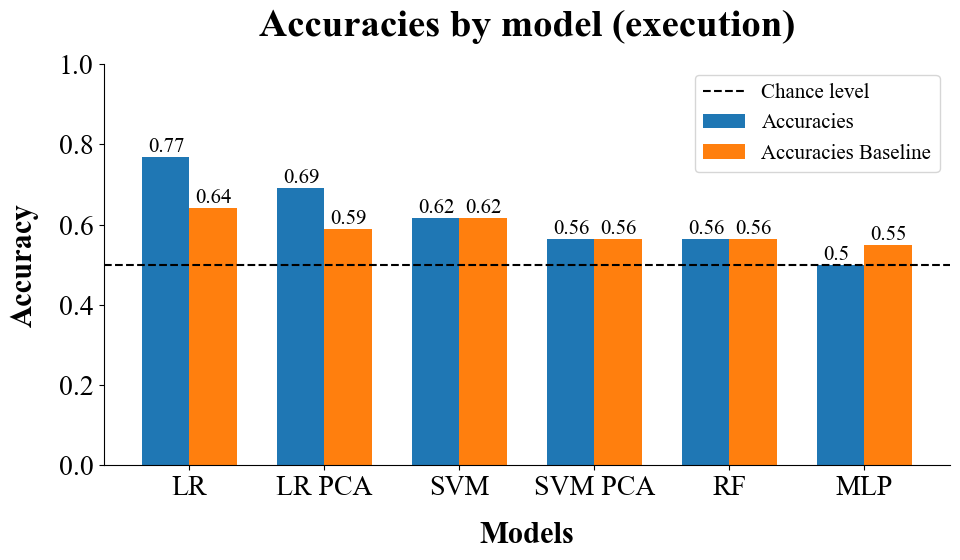

In [116]:
# General
plt.rcParams["font.family"] = "Times New Roman"
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold', titlepad = 20)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight = 'bold', labelpad = 15)   # fontsize of the x and y labels    
plt.rc('xtick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes.spines', top=False, right=False)  # Removing the top and right spines   

models = accuracies_ex.keys()

dataset_values = [accuracies_ex[model] for model in models]
baseline_values = [accuracies_ex_baseline[model] for model in models]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, dataset_values, width, label='Accuracies')
bars2 = ax.bar(x + width/2, baseline_values, width, label='Accuracies Baseline')

ax.set_xticks(x)
ax.set_xticklabels(models)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
ax.set_title('Accuracies by model (execution)')

ax.set_ylim(0,1)

ax.legend()

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
plt.axhline(0.5, linestyle='--', color='k', label='Chance level')
plt.legend(fontsize=15)

plt.tight_layout()
saved_dir = os.path.join(os.getcwd(), 'figures')
if not os.path.exists(saved_dir):
    os.makedirs(saved_dir)
plt.savefig('figures/accuracies_ex.png')
plt.show()


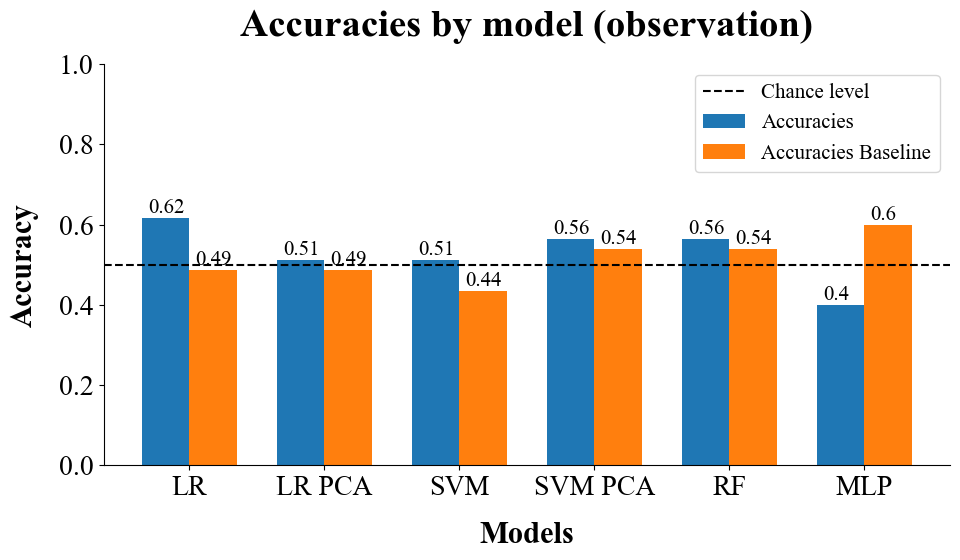

In [102]:
# General
plt.rcParams["font.family"] = "Times New Roman"
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold', titlepad = 20)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight = 'bold', labelpad = 15)   # fontsize of the x and y labels    
plt.rc('xtick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes.spines', top=False, right=False)  # Removing the top and right spines   

models = accuracies_obs.keys()

dataset_values = [accuracies_obs[model] for model in models]
baseline_values = [accuracies_obs_baseline[model] for model in models]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, dataset_values, width, label='Accuracies')
bars2 = ax.bar(x + width/2, baseline_values, width, label='Accuracies Baseline')

ax.set_xticks(x)
ax.set_xticklabels(models)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
ax.set_title('Accuracies by model (observation)')

ax.set_ylim(0,1)

ax.legend()

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)

plt.axhline(0.5, linestyle='--', color='k', label='Chance level')
plt.legend(fontsize=15)
  
plt.tight_layout()
saved_dir = os.path.join(os.getcwd(), 'figures')
if not os.path.exists(saved_dir):
    os.makedirs(saved_dir)
plt.savefig('figures/accuracies_obs.png')
plt.show()
